In [10]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import numpy as np
import pickle
import ipywidgets as widgets
from scipy.stats import norm
import time

import sys
import os
sys.path.insert(0, os.path.abspath('Practical04_Support'))

from Robot_SLAM import *
from Measurements import *
from SLAM_Renderer import *

# Coding Exercise: SLAM EKF (6 points)

Given the EKF implementation covered during the lecture, you are asked to extend it so to account for an unknown environment.

To do so, four main changes are necessary:

1. Add the marker position to the state vector $\boldsymbol{x}_\text{SLAM}$
2. Update the model and its corresponding covariance
3. Update the measurement covariance
4. Adapt the prediction and update states to take into account for the new definition of the state $\boldsymbol{x}_\text{SLAM}$

To complete this exercise, we provide you with a base SLAM class in which the logic of the following methods is missing (each method correspons to one of the main changes listed above):

- ``add_landmark(.)``, this method adds the position of a new marker to the robot's state. Please keep in mind that markers are sensed in the robot frame and should be transformed into the world frame
- ``state_transition(.)``, using a new control input, this method determines the robot's new state, and computes and returns $A$
- ``predict_covariance(.)``, using a new control input, this method computes and returns $\Sigma_Q$
- ``predict(.)`` and ``update(.)``, these are the main steps of our SLAM-EKF. 
  - In ``predict(.)``, make sure to compute the new robot's state given the control input recived as parameter. This method must update our robot's uncertainty ``self.P`` (please keep in mind that P = $\Sigma_t)$.
  - In ``update(.)``, make sure to use and update the extended state representation $\boldsymbol{x}_\text{SLAM}$. This method must also update our robot's uncertainty ``self.P`` (please keep in mind that P = $\Sigma_t$).
  
You can consult the `Practical04_Localisation_Mapping.ipynb` for some of the hint for implementing, with functions such as `covariance_drive`

**NOTE**: You do not need to tune the uncertainty parameter of the model and the sensors, please just use the default value.  

## SLAM base classs

In [83]:
class Slam:
    # Implementation of an EKF for SLAM
    # The state is ordered as [x; y; theta; l1x; l1y; ...; lnx; lny]

    # Utility
    # -------

    def __init__(self, robot):
        # State components
        self.robot = robot
        self.markers = np.zeros((2,0))
        self.taglist = []

        # Covariance matrix
        self.P = np.eye(3)*0.5
        self.init_lm_cov = 1e1

    def number_landmarks(self):
        return int(self.markers.shape[1])

    def get_state_vector(self):
        state = np.concatenate((self.robot.get_state(), 
                                np.reshape(self.markers, (-1,1), order='F')), axis=0)
        return state
    
    def set_state_vector(self, state):
        x, y, theta = state[0:3,:]
        self.robot.set_state(x, y, theta)
        self.markers = np.reshape(state[3:,:], (2,-1), order='F')
        
    
    # EKF functions
    # -------------

    def predict(self, raw_drive_meas):
        # The prediction step of EKF
        #TODO: 4 ----------------------------------------------------------------------
        # get current robot's state
        x = self.get_state_vector()
        # compute robot's state given the control input
        
        n_dims_add = (np.shape(self.P)[0]-3)/2
        
        # Get A using state_transition()
        A = np.pad(self.state_transition(raw_drive_meas), ((n_dims_add, np.shape(self.P)[0]),(n_dims_add, np.shape(self.P)[0])),'constant', constant_values=0)
        
        # Get Q using predict_covariance()
        Q = np.pad(self.predict_covariance(raw_drive_meas), ((n_dims_add, np.shape(self.P)[0]),(n_dims_add, np.shape(self.P)[0])),'constant', constant_values=0)

        print("Shape of x: ", end='')
        print(np.shape(x))
        print("Shape of A: ", end='')
        print(np.shape(A))
        print("Shape of Q: ", end='')
        print(np.shape(Q))
        print("Shape of P: ", end='')
        print(np.shape(self.P))
        print("Shape of x: ", end='')
        print(np.shape(x))

        # Update robot's uncertainty and update robot's state
        self.P = A@self.P@A.T+Q
            
        #ENDTODO ----------------------------------------------------------------------
        
    def update(self, measurements):
        if not measurements:
            return

        # Construct measurement index list
        tags = [lm.tag for lm in measurements]
        idx_list = [self.taglist.index(tag) for tag in tags]

        # Stack measurements and set covariance
        z = np.concatenate([lm.position.reshape(-1,1) for lm in measurements], axis=0)
        R = np.zeros((2*len(measurements),2*len(measurements)))
        for i in range(len(measurements)):
            R[2*i:2*i+2,2*i:2*i+2] = measurements[i].covariance

        # Update measurements
        #TODO: 5 ----------------------------------------------------------------------
        # Get location of measurements given robot's current state
        
        # Linearize measurement about robot's current state
        
        # Compute Kalman Gain
        
        # Correct state
        
        # Correct covariance
        
        #ENDTODO ----------------------------------------------------------------------


    def state_transition(self, raw_drive_meas):
        #TODO: 2 ----------------------------------------------------------------------
        n = self.number_landmarks()*2 + 3
        A = bot.derivative_drive(raw_drive_meas)
        
        #ENDTODO ----------------------------------------------------------------------
        return A
    
    def predict_covariance(self, raw_drive_meas):
        #TODO: 3 ----------------------------------------------------------------------
        n = self.number_landmarks()*2 + 3
        Q = bot.covariance_drive(raw_drive_meas)
        
        #ENDTODO ----------------------------------------------------------------------
        return Q
        
    def add_landmarks(self, measurements):
        if not measurements:
            return

        th = self.robot.theta
        robot_xy = self.robot.get_state()[0:2,:]
        R_theta = np.block([[np.cos(th), -np.sin(th)],[np.sin(th), np.cos(th)]])

        # Add new landmarks to the state
        for lm in measurements:
            if lm.tag in self.taglist:
                # ignore known tags
                continue
            
            #TODO: 1 ----------------------------------------------------------------------
            # Obtain the coordinates of the any new marker in world frame and add it to
            # the variable self.markers
            lm_robot = lm.position
            lm_world = lm_robot * R_theta # SUSEPECT ********************
            
            # append both taglist and markers
            self.taglist.append(lm.tag)
            self.markers = np.concatenate((self.markers, lm_world), axis=1)
            #ENDTODO ----------------------------------------------------------------------

            # Create a simple, large covariance to be fixed by the update step
            self.P = np.concatenate((self.P, np.zeros((2, self.P.shape[1]))), axis=0)
            self.P = np.concatenate((self.P, np.zeros((self.P.shape[0], 2))), axis=1)
            self.P[-2,-2] = self.init_lm_cov**2
            self.P[-1,-1] = self.init_lm_cov**2

## Running SLAM

In [84]:
#Here we load our data including the true state 
with open('Practical04_Support/data/slam_data.dat', "rb") as f:
    data = pickle.load(f)
    
true_state = data['state']
control = data['control']
measurements = data['measurement']
taglist = data['taglist']
landmark_pos = data['landmark_pos']


#Now lets see how well slam does
#Create a robot and place it at the true starting position and orientation 
bot = PenguinPi(0.14, 0.01)
# Set the initial state of the robot from the data
init_x, init_y, init_theta = true_state[0,:]
bot.set_state(x=init_x, y=init_y, theta=init_theta)

slammer = Slam(bot)

#----------------------------------------PARAMETERS----------------------------------
#
#Initial incertainty of our robot
slammer.P = np.eye(3)*0.1
#Uncertainty in our left and right wheel motors
sigma_drive = np.array([1,1])
#Uncertainty in measurement ~10cm
sigma_measure = np.eye(2)*0.5
#
#-------------------------------------------------------------------------------------

#------------------------------------ SLAM ----------------------------------------
#Our timestamp is always 0.2
dt = 0.2
#Here we will save our state variable 
state = np.zeros((control.shape[0],3))
#Here we will save all of the landmarks added to our map
landmarks = []
#Here we save the robot covariances
robot_cov = np.zeros(((control.shape[0],3,3)))
#Here we save the marker covariances
marker_cov = []
for c in range(control.shape[0]):
    #Set the measurement covariances
    for mes in measurements[c]:
        mes.covariance = sigma_measure 
    
    slammer.add_landmarks(measurements[c])
    # Drive and predict
    drive_signal = DriveMeasurement(control[c,0],control[c,1],dt,sigma_drive[0],sigma_drive[1])
    slammer.predict(drive_signal)
    slammer.update(measurements[c])
    
    marker_cov.append(slammer.P[3:,3:])
    state[c,:] = bot.get_state().flatten()
    #print("Robot's state: true {}, predicted {}".format(bot.get_state().flatten(), true_state[c,:]))
    landmarks.append(slammer.markers)
    robot_cov[c,:,:] = slammer.P[0:3,0:3]

# Calculate state error
pos_error_x= state[:,0] - true_state[:,0]
pos_error_y= state[:,1] - true_state[:,1]

# Calculate marker error
marker_error_x=np.zeros(len(state))
marker_error_y=np.zeros(len(state))
for i in range(len(state)):
    true_values = np.zeros((2,len(measurements[i])))
    predicted_values = np.zeros((2,len(measurements[i])))
    for j in range(len(measurements[i])):
        true_values[:,j] = landmark_pos[:,measurements[i][j].tag]
        predicted_values[:,j] = landmarks[i][:,slammer.taglist.index(measurements[i][j].tag)]
    
    marker_error_x[i]= np.mean(predicted_values[0,:] - true_values[0,:])
    marker_error_y[i]= np.mean(predicted_values[1,:] - true_values[1,:])  

TypeError: `pad_width` must be of integral type.

## Test your Solution

If your SLAM-EKF is implemented correctly, you should observe how the robot only uses the information of the markers that are directly visible in its camera. 

To know whether your solution is correct:
- Watch the evolution of the state and marker error. When using the default ``sigma_drive`` and ``sigma_measure`` values provided below, you should observe that:
    - Your state error and marker error are close to zero for both the $x$ and $y$ coordinates. 
- Take a look at video included in the Support folder (SLAM.mp4).
- Note: You will encouter error "invalid value encountered in true_divide" prior to completion of TODO2, 3 and 4

C:\Users\thean\OneDrive\Documents\1. Uni Work\2022\S2\ECE4078\ECE4078_Practicals_2022\Week04\Practical04_Support\SLAM_Renderer.py:177: RuntimeWarning: invalid value encountered in true_divide
  angle=np.rad2deg(np.arccos(v1[0]/np.linalg.norm(v1))))


Box(children=(IntSlider(value=0, description='Frame: ', layout=Layout(flex='3 1 0%', width='auto'), max=299), …

C:\Users\thean\OneDrive\Documents\1. Uni Work\2022\S2\ECE4078\ECE4078_Practicals_2022\Week04\Practical04_Support\SLAM_Renderer.py:315: RuntimeWarning: invalid value encountered in true_divide
  self.robo_ell.angle = np.rad2deg(np.arccos(v1[0]/np.linalg.norm(v1)))
C:\Users\thean\OneDrive\Documents\1. Uni Work\2022\S2\ECE4078\ECE4078_Practicals_2022\Week04\Practical04_Support\SLAM_Renderer.py:332: RuntimeWarning: invalid value encountered in true_divide
  self.marker_ells[i].angle = np.rad2deg(np.arccos(v1[0]/np.linalg.norm(v1)))
Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "C:\Users\thean\OneDrive\Documents\1. Uni Work\2022\S2\ECE4078\ECE4078_Practicals_2022\Week04\Practical04_Support\SLAM_Renderer.py", line 240, in run
    self.render()
  File "C:\Users\thean\OneDrive\Documents\1. Uni Work\2022\S2\ECE4078\ECE4078_Practicals_2022\Week04\Practical04_Support\SLAM_Ren

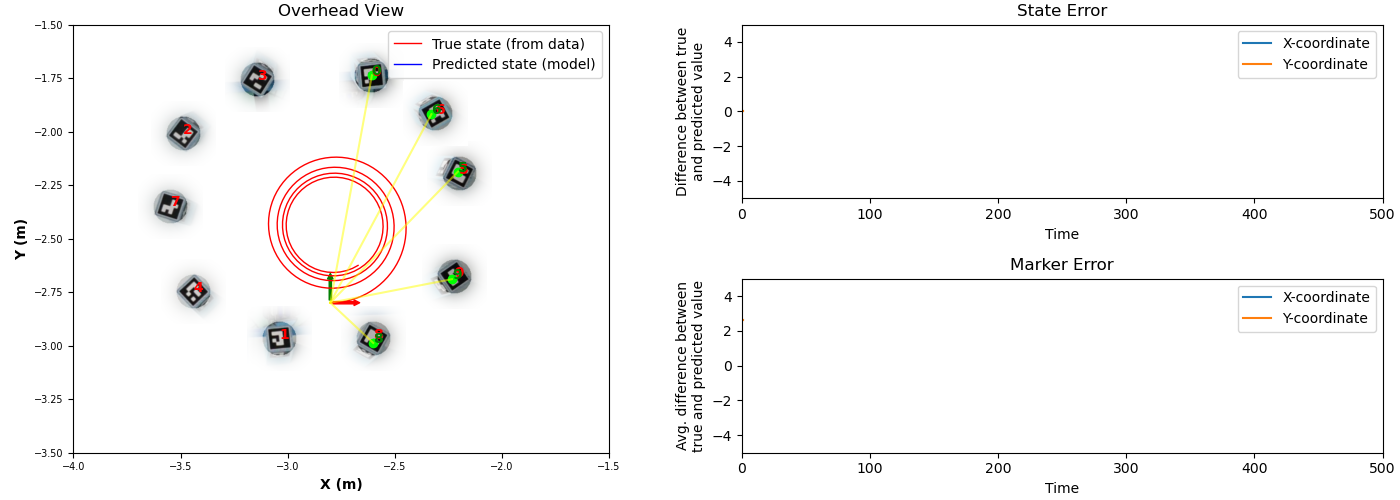

In [34]:
#Create a visualizer and visualize our atate
rend = Renderer.Instance()
rend.initialize(state, pos_error_x, pos_error_y, marker_error_x, marker_error_y, measurements, true_state = true_state,landmarks=landmarks,robot_cov=robot_cov,marker_cov=marker_cov,
               add_aruco=True)

# Grading
- In this notebook, we are evaluating the variable `state` and `slammer.markers` when you run the the third cell.
- Please add/eddit code of TODO sections only, do NOT round any values
- Passing All test cases here does not guarantee full mark, we will run `hidden_tests` with different scenarios (and stricters in terms of requirement)! But you can be sure that if you do notpass this test case, you will very likely receive 0.

In [ ]:
import otter
grader = otter.Notebook(tests_dir = "Practical04_Support/tests")
grader.check_all()